<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.1.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## *Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [2]:
data = pd.read_csv('ner_dataset.csv', encoding = 'latin1')
data = data.fillna(method='ffill')
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [3]:
print("Unique words in corpus :",data['Word'].nunique())
print("Unique tags in corpus :",data['Tag'].nunique())

Unique words in corpus : 35178
Unique tags in corpus : 17


In [4]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [5]:
tags = list(set(data['Tag'].values))
num_tags = len(tags)

### Retrieving Sentences and Corresponsing Tags

In [6]:
class SentenceGetter(object):
    def __init__(self,data):
        self.n_sent = 1
        self.data = data
        agg_func = lambda s:[(w, p, t)for w, p, t in zip(s["Word"].values.tolist(),
                                                        s["POS"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [7]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [8]:
sentences[2]

[('Helicopter', 'NN', 'O'),
 ('gunships', 'NNS', 'O'),
 ('Saturday', 'NNP', 'B-tim'),
 ('pounded', 'VBD', 'O'),
 ('militant', 'JJ', 'O'),
 ('hideouts', 'NNS', 'O'),
 ('in', 'IN', 'O'),
 ('the', 'DT', 'O'),
 ('Orakzai', 'NNP', 'B-geo'),
 ('tribal', 'JJ', 'O'),
 ('region', 'NN', 'O'),
 (',', ',', 'O'),
 ('where', 'WRB', 'O'),
 ('many', 'JJ', 'O'),
 ('Taliban', 'NNP', 'B-org'),
 ('militants', 'NNS', 'O'),
 ('are', 'VBP', 'O'),
 ('believed', 'VBN', 'O'),
 ('to', 'TO', 'O'),
 ('have', 'VB', 'O'),
 ('fled', 'VBN', 'O'),
 ('to', 'TO', 'O'),
 ('avoid', 'VB', 'O'),
 ('an', 'DT', 'O'),
 ('earlier', 'JJR', 'O'),
 ('military', 'JJ', 'O'),
 ('offensive', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('nearby', 'JJ', 'O'),
 ('South', 'NNP', 'B-geo'),
 ('Waziristan', 'NNP', 'I-geo'),
 ('.', '.', 'O')]

### Defining Mappings between Sentences and Tags

In [9]:
word2idx = {w: i+1 for i,w in enumerate(words)}
tag2idx ={t: i for i,t, in enumerate(tags)}

In [10]:
word2idx

{'unlawfully': 1,
 'profits': 2,
 'ripped': 3,
 'Amagasaki': 4,
 'enterprises': 5,
 'comply': 6,
 'Data': 7,
 'blossomed': 8,
 'airlifts': 9,
 'System': 10,
 'Royce': 11,
 'Baghaichhari': 12,
 'Ghost': 13,
 'Tangier': 14,
 'Elephants': 15,
 'Minar-e-Pakistan': 16,
 'endeavor': 17,
 'exchange': 18,
 'sight': 19,
 'Dragomir': 20,
 'Norwegians': 21,
 '19,000': 22,
 'Mossad': 23,
 'eggs': 24,
 'Abakar': 25,
 'combatant': 26,
 'reshape': 27,
 'Crumpton': 28,
 'Schops': 29,
 'Mahinda': 30,
 'Azimbek': 31,
 'Vujadin': 32,
 'Unseeded': 33,
 'sculptures': 34,
 'projecting': 35,
 'pounded': 36,
 'Alistair': 37,
 'Petronas': 38,
 'Pointe': 39,
 'mauled': 40,
 'Zafaraniyah': 41,
 'Nateghi': 42,
 'dismissal': 43,
 'Technical': 44,
 'mistrust': 45,
 'manifestation': 46,
 'Sonia': 47,
 'UNITA': 48,
 'Ellison': 49,
 'Campaigning': 50,
 'masterminded': 51,
 '1.08': 52,
 'SAA': 53,
 'Rate': 54,
 'U.S.-owned': 55,
 'USAID': 56,
 'turbo': 57,
 'Noordin': 58,
 'firsts': 59,
 '68-34': 60,
 'tsunami-producin

### Padding Input Sentences and Creating Train/Test Splits

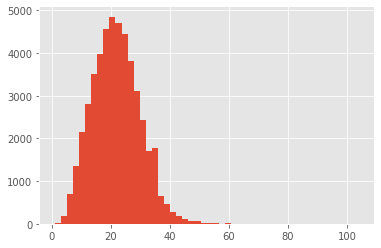

In [11]:
plt.hist([len(s) for s in sentences], bins =50)
plt.show()

In [22]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences =X, padding ='post', value = num_words-1)

y = [[tag2idx[w[2]] for w in s]for s in sentences]
y = pad_sequences(maxlen = max_len, sequences=y, padding='post', value=tag2idx["O"])
y = [to_categorical(i, num_classes = num_tags) for i in y] 

In [23]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

### Building and Compiling the Bidirectional LSTM Model

In [24]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [25]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

### Training the Model

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

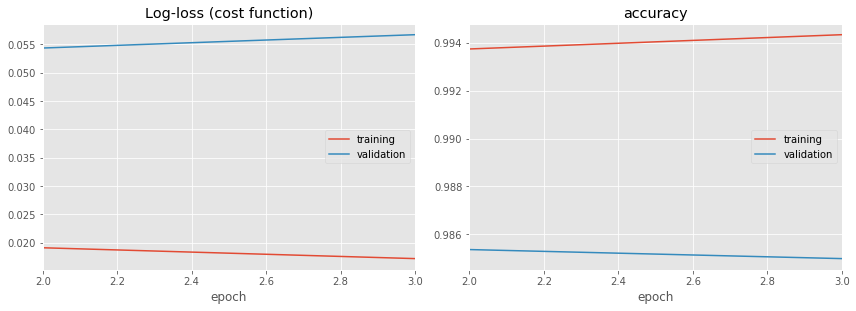

Log-loss (cost function):
training   (min:    0.017, max:    0.021, cur:    0.017)
validation (min:    0.052, max:    0.057, cur:    0.057)

accuracy:
training   (min:    0.993, max:    0.994, cur:    0.994)
validation (min:    0.985, max:    0.985, cur:    0.985)
34530/34530 [==============================] - 184s 5ms/sample - loss: 0.0172 - accuracy: 0.9943 - val_loss: 0.0567 - val_accuracy: 0.9850


In [31]:
early_stopping = EarlyStopping(monitor ='val_accuracy', patience=1, verbose =0, mode = 'max', restore_best_weights=False)
callbacks = [PlotLossesCallback(), early_stopping]

history = model.fit(
    x_train, np.array(y_train),
    validation_split = 0.2,
    batch_size = 32,
    epochs = 3,
    verbose =1,
    callbacks=callbacks
)

### Evaluating Named Entity Recognition Model

In [33]:
model.evaluate(x_test, np.array(y_test))

4796/4796 [==============================] - 5s 1ms/sample - loss: 0.0584 - accuracy: 0.9851


[0.05839354469067261, 0.9850667]

In [37]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis = -1)

y_true =np.argmax(np.array(y_test), axis = -1)[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-"*30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
The            B-org	B-org
Associated     I-org	I-org
Press          I-org	I-org
says           O	O
the            O	O
recommendation O	O
by             O	O
Colonel        O	O
James          B-per	B-per
Daniel         I-per	I-per
will           O	O
be             O	O
forwarded      O	O
to             O	O
Army           B-org	B-org
officials      O	O
for            O	O
a              O	O
final          O	O
decision       O	O
.              O	O
trivial        O	O
trivial        O	O
trivial        O	O
trivial        O	O
trivial        O	O
trivial        O	O
trivial        O	O
trivial        O	O
trivial        O	O
trivial        O	O
trivial        O	O
trivial        O	O
trivial        O	O
trivial        O	O
trivial        O	O
trivial        O	O
trivial        O	O
trivial        O	O
trivial        O	O
trivial        O	O
trivial        O	O
trivial        O	O
trivial        O	O
trivial        O	O
trivial        O	O
trivial        O	O
